In [1]:
import os
import sys 
import glob
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# TODO include for and aft viewing geometry in addition to mid, to obtain mutliple velocity vectors

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
files = glob.glob(f"{data_dir}*")
files


['/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201110T215700_20201110T215729_035192_041BDB_BB87.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201110T215610_20201110T215635_035192_041BDB_5339.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201104T173336_20201104T173401_035101_0418AF_0F41.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201104T173242_20201104T173311_035101_0418AF_69EB.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201104T173311_20201104T173336_035101_0418AF_189E.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201110T215635_20201110T215700_035192_041BDB_DA2D.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/S1A_IW_GRDH_1SDV_20201107T090417_20201107T090442_035140_0419FD_0787.SAFE']

In [4]:
test_files = [files[i] for i in [0,1, 5]] # [1,2,5]

test = S1DopplerLeakage(
    filename=test_files,
    era5_nc='era520201110.nc',
    )

In [5]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_Doppler_leakage()

In [6]:
test.apply()

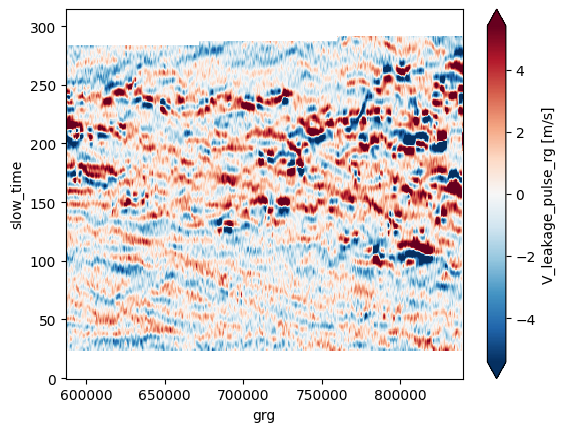

In [7]:
test.data.V_leakage_pulse_rg.T.plot(robust = True)
# test.subscenes.V_leakage_pulse_rg.T.plot(robust = True)